In [241]:
%matplotlib notebook

In [242]:
%run ./setup_notebook.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [243]:
# notebook specific imports
import pickle
import gsheets_importer
import math
import copy
from scipy import stats
import time
import random
import utils.utils_funcs as utils
from subsets_analysis import Subsets

In [244]:
mouse = 'J048'
run_number = '27'

packerstation_path = '/home/jamesrowland/Documents/packerstation/jrowland/Data'
pkl_path = '/home/jamesrowland/Documents/Code/Vape/run_pkls/{}/run{}.pkl'.format(mouse, run_number)

with open(pkl_path, 'rb') as f:
    run = pickle.load(f)
    
subsets = Subsets(run)

In [245]:
run.__dict__.keys()

dict_keys(['mouse_id', 'df', 'rows_2p', 'rows_1p', 'dates_2p', 'paqs', 'naparm_folders', 'blimp_folders', 'pycontrol_folders', 'prereward_folders', 'tseries_folders', 'plane_numbers', 'run_pycontrol_txt', 'num_planes', 'blimp_path', 'naparm_path', 'pycontrol_path', 'paq_path', 'prereward_path', 'tseries_paths', 'align_barcode', 'trial_info', 'session', 'print_lines', 'trial_time', 'outcome', 'slm_barcode', 'slm_trial_number', 'nogo_barcode', 'nogo_trial_number', 'alltrials_barcodes', 'rsync', 'trial_start', 'paq_rsync', 'frame_clock', 'x_galvo_uncaging', 'slm2packio', 'paq_rate', 'aligner', 'paq_correct', 'pre_rsync', 'pre_licks', 'pre_reward', 'prereward_aligner', 'both_aligner', 'num_frames', 's2p_path', 'flu_raw', 'flu', 'spks', 'stat', 'frames_ms'])

In [246]:
figure_path = '/home/jamesrowland/Documents/Code/Vape/figures/s1s2_imaging_subsets_prototype'

In [247]:
frames_ms = run.frames_ms
flu = run.flu
n_cells = flu.shape[0]
x_galvo_uncaging = run.x_galvo_uncaging#[::1000]
tstart_galvo = utils.threshold_detect(x_galvo_uncaging, 0)

In [248]:
# plt.plot(x_galvo_uncaging)
# utils.raster_plot(tstart_galvo, y_pos=0, color='red')
# utils.raster_plot(run.both_aligner.A_to_B(run.trial_start))

In [249]:
#assert len(run.outcome) == len(subsets.trial_subsets) == len(run.trial_start) == len(tstart_galvo)

intersect = lambda A, B: list(set(A) - (set(A) - set(B)))

stim_idx = np.where(subsets.trial_subsets==150)[0]

stim_times = run.trial_start[stim_idx]
stim_times[21]

1601423

### Toggle cell below on to switch to paqio alignment

In [250]:
# stim_times = tstart_galvo[stim_idx]

# num_planes = run.num_planes 
# tseries_lens = run.num_frames

# # get the frame ttls recorded in paqio that actually correspond to analysed tseries
# paqio_frames = utils.tseries_finder(tseries_lens, run.frame_clock)

# # which plane is each cell in
# cell_plane = np.array([s['iplane'] for s in run.stat])

# # matrix of frame times in ms for each fluorescent value in the flu matrix
# frames_ms = np.empty(flu.shape)
# frames_ms.fill(np.nan)

# num_planes = 3

# # mark each frame with a time in ms based on its plane
# for plane in range(num_planes):
#     frame_times = paqio_frames[plane::num_planes]
#     plane_idx = np.where(cell_plane==plane)[0]
#     frames_ms[plane_idx, 0:len(frame_times)] = frame_times

In [251]:
%%capture
pre_frames = 10
post_frames = 30

tot_frames = pre_frames + post_frames

stim_idxs = utils.stim_start_frame_mat(stim_times, frames_ms)
boi = copy.deepcopy(stim_idxs)

stim_idxs = stim_idxs[:,np.where((stim_idxs[0,:]-pre_frames>0) & 
                     (stim_idxs[0,:] + post_frames < flu.shape[1]))[0]]

n_trials = stim_idxs.shape[1]

for i, shift in enumerate(np.arange(-pre_frames,post_frames)):
    
    if i == 0: 
        trial_idx = stim_idxs + shift
    else:
        trial_idx = np.dstack((trial_idx, stim_idxs + shift))
        
trial_idx = trial_idx.reshape((n_cells, n_trials*tot_frames))
trial_idx.shape

In [252]:
flu_trials = []

for i, idxs in enumerate(trial_idx):
    idxs = idxs[~np.isnan(idxs)].astype('int')
    flu_trials.append(flu[i,idxs])
  
n_trials_valid = len(idxs)
    
flu_trials = np.array(flu_trials).reshape((n_cells, int(n_trials_valid/tot_frames), tot_frames))
flu_trials = np.array(flu_trials)
flu_trials.shape

(2101, 30, 40)

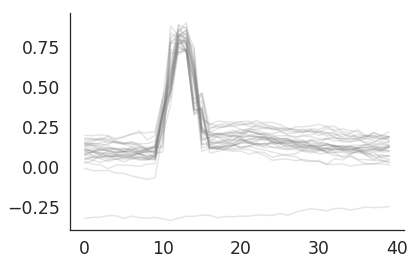

In [253]:
cell_meaned = np.mean(flu_trials,0)
mean_trial = np.mean(flu_trials, 2)
av = np.mean(np.mean(flu_trials, 1), 0)
#plt.plot(av)
for i, c in enumerate(cell_meaned):
    
#     if c[11] > 0.4:
#         print(i)

    plt.plot(c, alpha=0.2, color='grey')